In [1]:
%%capture
import os
from IPython.display import Javascript

os.environ['R_HOME'] = 'C:\Program Files\R\R-4.4.2'
%load_ext rpy2.ipython

%run -i ./MDT_Functions.py

C:\Users\alifr\anaconda3\envs\ericapp\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


D:\ABMI_Official\EricCodePractice\EWNeilsen_OccupancySpatialPowerApp
The study area has (417996.4415538451, 795945.195356781, 1126884.4543278955, 1581144.825542611). 
It has 76 rows and 91 columns.

------------------
Finished inputing Use vars: ['elevation', 'water_proximity']

------------------
Used the inputted rasters to simulate the spatial probability of use across study area.

------------------


Converting use into occupancy. What is the true proportion of the area that is occupied (number between 0 and 1)? 0.51


There are 3523 occupied pixels (88075.0 km occupied area). This leads to an instantaneous probability of detection in any cell for one, randomly moving, individual of 0.0003

------------------


Simulate a population within the occupied cells using a population density. What is the density of individuals per km2 (0.001 - 1)? 0.05



With a density of 0.05 individuals per pixel across all occupied pixels, the total population is 4403.75. This gives an instantaneous probability of use of any occupied cell, of any randomly moving individual, of 1
The mean instantaneous probability of detection across occupied cells, for any randomly moveing individual, is 0.54

Finished calculating distribution vars: ['Use', 'Occupancy', 'Detection']


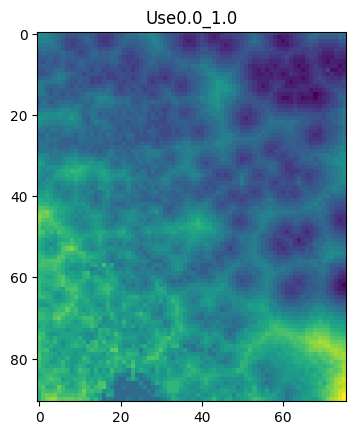

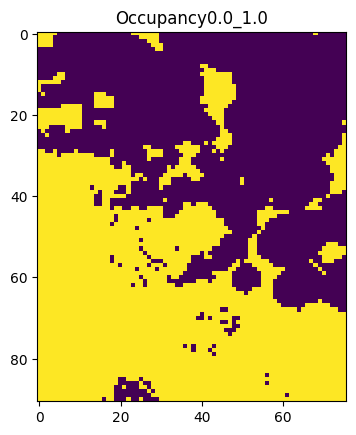

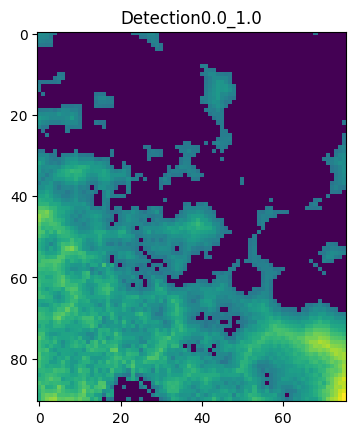

In [2]:
0.01### INPUT DATA
inputSpatial()

# SIMULATE RESPONSE
simulateReponse()

# ## simulate resposne
# Javascript("Jupyter.notebook.execute_cells([2])")

In [3]:
## SIMULATE OCCUANPCY DATA
simulateOccupancyData()

Enter the configuration of cameras 
 (1) Systematic
 (2) Random
 (3) Stratigied Random 
 1


------------------


Enter the number of site scenarios. 4
Enter the max number of cameras. 60
Enter the min number of cameras. 40
Enter the number of duration scenarios. 4
Enter the max duration of deployments (weeks). 8
Enter the min duration of deployments (weeks). 4


In [4]:
%R -i cwd
%R -i trueOcc
%R -i popPX
%R -i N
%R -i meanDetection

# display(Javascript("Jupyter.notebook.execute_cells([4])"))


In [5]:
%%R

library(unmarked)
options(warn=2)

getParams = function(modObject){
    
    outParams = list()
    psiTab = predict(modObject, type="state",newdata=data.frame(1))
    outParams$psi = psiTab$Predicted
    outParams$psiSE = psiTab$SE
    outParams$psiBias = outParams$psi - trueOcc
    
    pTab = predict(modObject, type="det",newdata=data.frame(1))
    outParams$p = pTab$Predicted
    outParams$pSE = pTab$SE
    outParams$pBias = outParams$p - meanDetection
    
    return(outParams)
    }


OccOutTab = data.frame(CamN = NA, IntervalsN = NA, Response = NA, Estimate = NA,
                       SE = NA, Bias = NA, inSig = NA)


dhScenDirs = list.dirs(paste0(cwd,'/Data/DetectionHistories'),recursive = FALSE)  
# print(dhScenDirs)
scenCount = 0
FailCount = 0 

for (dir in dhScenDirs){    

    scenI = unlist(strsplit(dir,"/"))
    scen = scenI[length(scenI)]
    scen = unlist(strsplit(scen,"_"))
    CameraNumber = scen[1]
    VisitsNumber = scen[2]

    dhScens = list.files(dir,pattern="\\.csv$")
    
    for (scen in dhScens){        
        dh = read.csv(paste0(dir,"/",scen),header=T)

        ## fit model to scenario data
        umf <- unmarkedFrameOccu(y=as.matrix(dh)) # organize data
        fm <- try(occu(~1 ~1, umf)) # fit a model
        modOut = try(coef(fm)) 
#         print('')
#         print('')
#         print(class(fm))
        
        if(class(modOut) != "try-error" ){    

#             ## model outputs
#             psiTab = predict(fm, type="state",newdata=data.frame(1))
#             psi = psiTab$Predicted
#             psiSE = psiTab$SE
#             psiBias = psi - trueOcc
#             pTab = predict(fm, type="det",newdata=data.frame(1))
#             p = pTab$Predicted
#             pSE = pTab$SE
#             pBias = p - meanDetection
            
            OP = try(getParams(fm))
            if(class(OP)!= "try-error"){

                ## occupancy info
                scenCount = scenCount + 1
                OccOutTab[scenCount,"CamN"] = CameraNumber
                OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
                OccOutTab[scenCount,"Response"] = "psi"
                OccOutTab[scenCount,"Estimate"] = OP$psi
                OccOutTab[scenCount,"SE"] = OP$psiSE
                OccOutTab[scenCount,"Bias"] = OP$psiBias
                OccOutTab[scenCount,"inSig"] = dplyr::between(0,OP$psi-(OP$psiSE*2.58),OP$psi+(OP$psiSE*2.58))

                ## detection info
                scenCount = scenCount + 1
                OccOutTab[scenCount,"CamN"] = CameraNumber
                OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
                OccOutTab[scenCount,"Response"] = "p"
                OccOutTab[scenCount,"Estimate"] = OP$p
                OccOutTab[scenCount,"SE"] = OP$pSE
                OccOutTab[scenCount,"Bias"] = OP$pBias
                OccOutTab[scenCount,"inSig"] = dplyr::between(0,OP$p-(OP$pSE*2.58),OP$p+(OP$pSE*2.58))
            }
            else{
                FailCount = FailCount + 1 
                print("Model failed")
            }
        }
        else{
            FailCount = FailCount + 1 
            print("Model failed")
        }
    }
}



print("Fit occupancy models to all detection histories.")
print(paste0(FailCount," models failed."))

[1] "Fit occupancy models to all detection histories."
[1] "0 models failed."


In [6]:
%%R
options(warn=1)
# print(OccOutTab)
require(tidyverse)

# print(OccOutTab %>% filter(Estimate>0.9999))

SumTab = OccOutTab %>%
    filter(!inSig)%>%
    group_by(CamN, IntervalsN, Response) %>%
    summarise(
        N = length(Estimate),
        
        meanEstimate = mean(Estimate),
        sdEstimate = sd(Estimate),
        seEstimate   = sdEstimate / sqrt(N),
        UpperCI_Est = quantile(Estimate,probs = 0.9),
        LowerCI_Est = quantile(Estimate,probs = 0.1),
        
        meanSE = mean(SE),
        sdSE = sd(SE),
        seSE   = sdSE / sqrt(N),
        UpperCI_SE = quantile(SE,probs = 0.9),
        LowerCI_SE = quantile(SE,probs = 0.1),
        
        meanBias = mean(Bias),
        sdBias = sd(Bias),
        seBias   = sdBias / sqrt(N),
        UpperCI_Bias = quantile(Bias,probs = 0.9),
        LowerCI_Bias = quantile(Bias,probs = 0.1)) %>%

    mutate(CamN = as.factor(CamN),
           Durations = as.numeric(IntervalsN))


print(SumTab)
print(meanDetection)

R[write to console]: Loading required package: tidyverse



-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
`summarise()` has grouped output by 'CamN', 'IntervalsN'. You can override using the `.groups` argument.
# A tibble: 8 x 20
# Groups:   CamN, IntervalsN [4]
  CamN  IntervalsN Response     N meanEstimate sdEstimate seEstimate UpperCI_Est
  <fct> <chr>      <chr>    <int>        <dbl>      <dbl>      <dbl>       <dbl>
1 41    4          p           10        0.556    0.0674     0.0213        0.

R[write to console]: Warning:
R[write to console]:  Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.



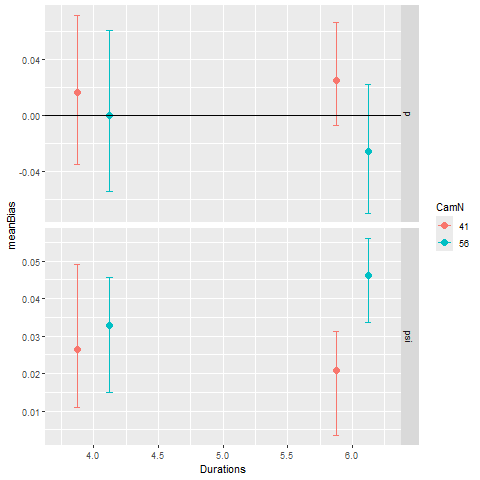

In [7]:
%%R


pd <- position_dodge(0.5)
SumTab %>%
    filter(!is.na(sdEstimate),meanEstimate < 0.99, meanEstimate > 0.001)%>%
    ggplot(
        aes(x=Durations, y=meanBias,ymin=LowerCI_Bias, ymax=UpperCI_Bias, colour=CamN)) + 
        #aes(x=Durations, y=meanEstimate,ymin=UpperCI_Est, ymax=LowerCI_Est, colour=CamN)) +
        geom_errorbar(width=0.1,position = pd)+
        geom_point(size = 3, position = pd) +        
        facet_grid(Response~.,scales="free") +
        geom_abline(size=0.5,intercept = 0, slope=0) 
#         ylim(0,1)+
#         theme(panel.border = element_blank(), panel.grid.major = element_blank(),
#               axis.line = element_line(colour = "black"))
# #         geom_abline(size=0.5,intercept = trueOcc, slope=0)

In [17]:
import rpy2.robjects as ro
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

# Define R script to generate and save the plot
r_script = """
library(ggplot2)
library(dplyr)

pd <- position_dodge(0.5)

# Generate the plot and save as PNG
plot_path <- "new_r_plot.png"

p <- SumTab %>%
    filter(!is.na(sdEstimate), meanEstimate < 0.99, meanEstimate > 0.001) %>%
    ggplot(aes(x=Durations, y=meanBias, ymin=LowerCI_Bias, ymax=UpperCI_Bias, colour=CamN)) +
        geom_errorbar(width=0.1, position=pd) +
        geom_point(size=3, position=pd) +
        facet_grid(Response~., scales="free") +
        geom_abline(size=0.5, intercept=0, slope=0)

ggsave(plot_path, p, width=6, height=4, dpi=100)
"""

# Run the R script in Python
ro.r(r_script)

# # Load the saved image in Python
# with open("r_plot.png", "rb") as file:
#     image_data = file.read()

# plot_widget = widgets.Image(
#                     value=image_data,
#                     format='png'
#                 )
# display(plot_widget)  # Display the plot in Jupyter Notebook

'new_r_plot.png'


In [18]:
secondGraphOut = widgets.Output()

In [19]:
with secondGraphOut:
    secondGraphOut.clear_output(wait=True)  # Clear previous plot
    # Convert R's StrVector to a regular Python string
    plot_path = ro.globalenv["plot_path"]
    plot_path = str(plot_path[0])  # Extract the string value
    
    # # Ensure the path is correct
    # print("Plot saved at:", plot_path)  # Debugging step

    #################################
    # plot_widget = Image.open(plot_path)
    print(plot_path)

    with open("new_r_plot.png", "rb") as file:
        image_data = file.read()

    plot_widget = widgets.Image(
                        value=image_data,
                        format='png'
                    )
    # Open and display the saved plot using ipywidgets
    # with open(plot_path, "rb") as f:
    #     plot_widget = widgets.Image(value=f.read(), format='png')
    # Wrap it inside a VBox container
    graph2_first_container = widgets.VBox(
                    [plot_widget],
                    layout=widgets.Layout(
                        width="60%",
                        display="flex",
                        align_items="center",  # Centers along the cross-axis
                        justify_content="center",  # Centers along the main axis
                        margin="auto"  # Centers the box itself
                    )
                )
    display(graph2_first_container)

In [21]:
 graph2_container = widgets.VBox([secondGraphOut],
                        layout=widgets.Layout(
                            width = "100%",
                            flex_flow="column",
                            align_items="center",
                            border="2px solid black"  # 2px black border
                        ))
display(graph2_container)

In [8]:
%whos

Variable                Type                Data/Info
-----------------------------------------------------
Javascript              type                <class 'IPython.core.display.Javascript'>
N                       float               51870.0
askQuestion             function            <function askQuestion at 0x0000019F54BB20C0>
cell_size               int                 5000
cwd                     str                 D:\ABMI_Official\EricCode<...>_OccupancySpatialPowerApp
extent                  tuple               n=4
gdal                    module              <module 'osgeo.gdal' from<...>ackages\\osgeo\\gdal.py'>
gdalconst               module              <module 'osgeo.gdalconst'<...>es\\osgeo\\gdalconst.py'>
inputSpatial            function            <function inputSpatial at 0x0000019F5538D440>
inspect                 module              <module 'inspect' from 'C<...>ricapp\\Lib\\inspect.py'>
json                    module              <module 'json' from 'C:\\<...>\Lib